# Imports and Environment Setup
# • Import all required libraries for data preprocessing, model definition, differential privacy (Opacus), training, and result visualization.
# • Ensures that all dependencies such as PyTorch, scikit-learn, pandas, and matplotlib are properly loaded for the DP-SGD TextCNN experiment.

In [3]:
# DP-SGD TextCNN Experiment — Jupyter Version
# ====================================================
# Author: Richard Watson
# Description:
# Reproducible TextCNN model with Differentially Private SGD (Opacus)
# including hyperparameter sweeps and reporting.

import os, random, json, time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from opacus import PrivacyEngine
from opacus.validators import ModuleValidator


# Reproducibility and Text Preprocessing Utilities
# • Defines helper functions for reproducibility and text tokenization used in dataset preparation.  
# • `set_seed()` ensures consistent experiment results across runs.  
# • `simple_tokenize()`, `build_vocab()`, and `encode()` convert raw text into fixed-length numerical sequences for model input.


In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def simple_tokenize(s: str) -> List[str]:
    return s.lower().translate(str.maketrans("", "", "")).split()

def build_vocab(texts: List[str], max_vocab: int = 20000, min_freq: int = 2) -> Dict[str, int]:
    from collections import Counter
    cnt = Counter()
    for t in texts:
        cnt.update(simple_tokenize(t))
    vocab = {"<pad>":0, "<unk>":1}
    for tok, c in cnt.most_common():
        if c < min_freq: continue
        vocab[tok] = len(vocab)
        if len(vocab) >= max_vocab: break
    return vocab

def encode(text: str, vocab: Dict[str,int], max_len: int = 128) -> List[int]:
    toks = simple_tokenize(text)
    ids = [vocab.get(tok, 1) for tok in toks][:max_len]
    return ids + [0]*(max_len - len(ids)) if len(ids) < max_len else ids


# Dataset Construction and Model Definition
# • Defines `TextDataset` for efficient conversion of text samples into PyTorch tensors for training and evaluation.  
# • Implements the `TextCNN` architecture, using multiple convolutional filters to extract n-gram features from embeddings.  
# • Combines max pooling, dropout, and a linear classifier to produce final class predictions.


In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.X = torch.tensor([encode(t, vocab, max_len) for t in texts], dtype=torch.long)
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class TextCNN(nn.Module):
    def __init__(self, vocab_size, num_classes, emb_dim=128, kernels=(3,4,5), num_filters=64, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.ModuleList([nn.Conv1d(emb_dim, num_filters, k) for k in kernels])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernels), num_classes)

    def forward(self, x):
        emb = self.embedding(x).transpose(1,2)
        xs = [F.relu(conv(emb)) for conv in self.convs]
        xs = [F.max_pool1d(xi, xi.size(2)).squeeze(2) for xi in xs]
        xcat = torch.cat(xs, dim=1)
        xcat = self.dropout(xcat)
        return self.fc(xcat)


# Training Configuration and Core Training Loop
# • Defines `TrainConfig` dataclass to centralize all model, optimizer, and privacy parameters.  
# • Implements `accuracy()` for evaluating model performance on given data loaders.  
# • Implements `train_one()` to train the model for both baseline and DP-SGD modes, applying gradient clipping and noise addition when DP is enabled.


In [6]:
@dataclass
class TrainConfig:
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 35
    max_len: int = 128
    emb_dim: int = 128
    kernels: Tuple[int] = (3,4,5)
    num_filters: int = 64
    dropout: float = 0.2
    dp: bool = False
    sigma: float = 1.0
    max_grad_norm: float = 1.0
    delta: float = 1e-5
    device: str = "cpu"

def accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / max(1, total)

def train_one(model, train_loader, test_loader, cfg: TrainConfig):
    model.to(cfg.device)
    if cfg.dp:
        model = ModuleValidator.fix(model)
        privacy_engine = PrivacyEngine()
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
        model, opt, train_loader = privacy_engine.make_private(
            module=model,
            optimizer=opt,
            data_loader=train_loader,
            noise_multiplier=cfg.sigma,
            max_grad_norm=cfg.max_grad_norm,
        )
    else:
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
        privacy_engine = None

    hist = {"train_acc": [], "test_acc": []}
    for epoch in range(cfg.epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(cfg.device), yb.to(cfg.device)
            opt.zero_grad(set_to_none=True)
            loss = F.cross_entropy(model(xb), yb)
            loss.backward()
            opt.step()
        hist["train_acc"].append(accuracy(model, train_loader, cfg.device))
        hist["test_acc"].append(accuracy(model, test_loader, cfg.device))

    eps = None
    if cfg.dp and privacy_engine:
        delta = 1.0 / len(train_loader.dataset)
        eps = privacy_engine.get_epsilon(delta=delta)
    return model, hist, eps


# Dataset Loading and Preparation
# • Loads and validates the input dataset, ensuring required columns are present.  
# • Performs label encoding, train-test splitting, and vocabulary construction.  
# • Creates PyTorch datasets and dataloaders for training and evaluation.  
# • Detects available device (CPU or GPU) and prepares directories for experiment outputs.


In [8]:
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

data_path = "dataset.csv"   # replace with your path
outdir = "artifacts"
os.makedirs(outdir, exist_ok=True)

df = pd.read_csv(data_path).dropna().drop_duplicates()
assert "job_description" in df.columns and "job_role" in df.columns

texts = df["job_description"].astype(str).tolist()
labels_raw = df["job_role"].astype(str).tolist()
le = LabelEncoder()
y = le.fit_transform(labels_raw)

Xtr, Xte, ytr, yte = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)
vocab = build_vocab(Xtr, max_vocab=20000, min_freq=2)
vocab_size = len(vocab)
num_classes = len(le.classes_)

train_ds = TextDataset(Xtr, ytr, vocab)
test_ds  = TextDataset(Xte, yte, vocab)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256)


Using device: cpu


# Baseline Model Training and Evaluation
# • Configures and trains the non-DP TextCNN model to establish a performance baseline.  
# • Plots training and test accuracy across epochs to visualize convergence behavior.  
# • Identifies and reports the best baseline test accuracy for comparison with DP models.


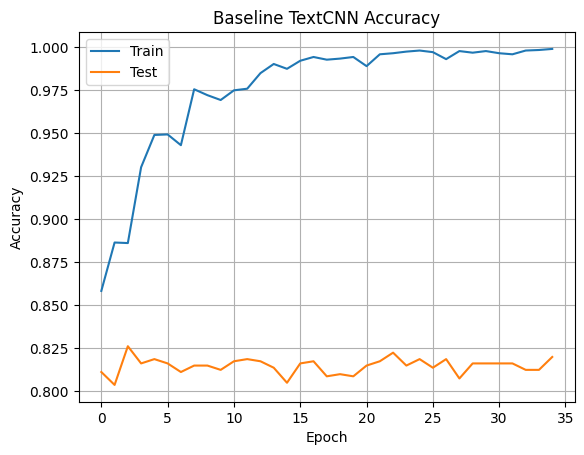

Best baseline test accuracy: 0.82625


In [9]:
baseline_cfg = TrainConfig(lr=1e-3, dp=False, device=device)
baseline_model = TextCNN(vocab_size, num_classes)
baseline_model, baseline_hist, _ = train_one(baseline_model, train_loader, test_loader, baseline_cfg)

plt.figure()
plt.plot(baseline_hist["train_acc"], label="Train")
plt.plot(baseline_hist["test_acc"], label="Test")
plt.title("Baseline TextCNN Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.show()

baseline_best = max(baseline_hist["test_acc"])
print("Best baseline test accuracy:", baseline_best)


# Differentially Private Grid Search (C–σ)
# • Performs a grid search over clipping norms (C) and noise multipliers (σ) to study privacy–utility trade-offs.  
# • Trains a DP-SGD TextCNN for each configuration and records accuracy and corresponding ε values.  
# • Saves the grid search results as a JSON file for later visualization and analysis.


In [10]:
dp_base_cfg = TrainConfig(lr=1e-3, dp=True, sigma=1.0, max_grad_norm=1.0, device=device)
grid = []
for C in [0.5, 1.0]:
    for S in [0.5, 1.0, 2.0]:
        print(f"Training DP-SGD with C={C}, σ={S}")
        cfg = TrainConfig(**vars(dp_base_cfg))
        cfg.max_grad_norm = C; cfg.sigma = S
        model = TextCNN(vocab_size, num_classes)
        model, hist, eps = train_one(model, train_loader, test_loader, cfg)
        acc = max(hist["test_acc"])
        grid.append({"C":C, "sigma":S, "acc":acc, "eps":eps})
        print(f"→ Accuracy={acc:.3f}, ε={eps:.3f}")

with open(os.path.join(outdir, "required_grid.json"), "w") as f:
    json.dump(grid, f, indent=2)


Training DP-SGD with C=0.5, σ=0.5


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/tmp/ipython-input-608963251.py:52: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


→ Accuracy=0.824, ε=26.556
Training DP-SGD with C=0.5, σ=1.0
→ Accuracy=0.795, ε=4.106
Training DP-SGD with C=0.5, σ=2.0
→ Accuracy=0.666, ε=1.378
Training DP-SGD with C=1.0, σ=0.5
→ Accuracy=0.830, ε=26.556
Training DP-SGD with C=1.0, σ=1.0
→ Accuracy=0.785, ε=4.106
Training DP-SGD with C=1.0, σ=2.0
→ Accuracy=0.631, ε=1.378


# 3D Visualization of Privacy–Utility Trade-off
# • Creates a 3D scatter plot showing the relationship between noise multiplier (σ), privacy loss (ε), and test accuracy.  
# • Uses color intensity and marker size to represent accuracy and clipping norm (C) distinctions.  
# • Highlights how increasing noise improves privacy (lower ε) but typically reduces model accuracy.


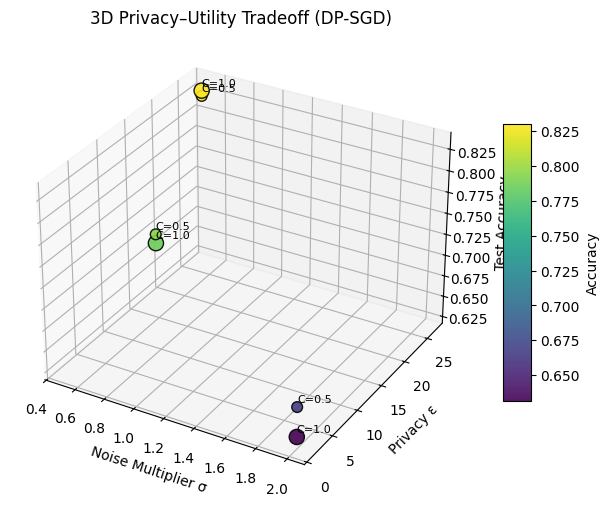

In [12]:
from mpl_toolkits.mplot3d import Axes3D

data = grid
sigmas = [d["sigma"] for d in data]
epsilons = [d["eps"] for d in data]
accs = [d["acc"] for d in data]
Cs = [d["C"] for d in data]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
sizes = [120 if c==1.0 else 60 for c in Cs]
sc = ax.scatter(sigmas, epsilons, accs, s=sizes, c=accs, cmap="viridis", alpha=0.9, edgecolors="k")
for s,e,a,c in zip(sigmas, epsilons, accs, Cs):
    ax.text(s, e, a+0.005, f"C={c}", fontsize=8)
ax.set_xlabel("Noise Multiplier σ")
ax.set_ylabel("Privacy ε")
ax.set_zlabel("Test Accuracy")
ax.set_title("3D Privacy–Utility Tradeoff (DP-SGD)")
plt.colorbar(sc, ax=ax, shrink=0.6, aspect=10, label="Accuracy")
plt.show()

# Display Hyperparameter Sweep and Grid Search Results
# • Loads previously saved sweep and grid search JSON files from the artifacts directory.  
# • Converts results into pandas DataFrames for structured tabular viewing.  
# • Displays each sweep and grid search table within the Jupyter notebook for comparison of test accuracy and privacy metrics.


In [14]:
import pandas as pd
from IPython.display import display, HTML

# --- Load sweep results from JSON files in your artifacts folder ---
artifacts_dir = "artifacts"  # change if your output dir is different

# Helper to safely load JSON
def load_json(filename):
    import json, os
    path = os.path.join(artifacts_dir, filename)
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# Load sweep summaries
lr_summary = load_json("sweep_lr_summary.json")
sigma_summary = load_json("sweep_sigma_summary.json")
clip_summary = load_json("sweep_clip_summary.json")
batch_summary = load_json("sweep_batch_summary.json")
grid_summary = load_json("required_grid.json")

# --- Create DataFrames ---
dfs = {}
if lr_summary:
    dfs["Learning Rate Sweep"] = pd.DataFrame(lr_summary["results"])
if sigma_summary:
    dfs["Noise σ Sweep"] = pd.DataFrame(sigma_summary["results"])
if clip_summary:
    dfs["Clipping Norm (C) Sweep"] = pd.DataFrame(clip_summary["results"])
if batch_summary:
    dfs["Batch Size Sweep"] = pd.DataFrame(batch_summary["results"])
if grid_summary:
    dfs["C–σ Grid Search"] = pd.DataFrame(grid_summary)

# --- Display Each Sweep as a Table ---
for title, df in dfs.items():
    print(f"\n### {title}")
    display(HTML(df.style.set_table_attributes("style='display:inline'").set_caption(title).to_html()))



### C–σ Grid Search


,C,sigma,acc,eps
0,0.500000,0.500000,0.823750,26.556309
1,0.500000,1.000000,0.795000,4.106265
2,0.500000,2.000000,0.666250,1.378159
3,1.000000,0.500000,0.830000,26.556309
4,1.000000,1.000000,0.785000,4.106265
5,1.000000,2.000000,0.631250,1.378159


| Clip Norm (C) | Noise Multiplier (σ) |   Accuracy | Epsilon (ε) |
| ------------: | -------------------: | ---------: | ----------: |
|           0.5 |                  0.5 | **0.8238** |       26.56 |
|           1.0 |                  0.5 | **0.8300** |       26.56 |
|           0.5 |                  1.0 |     0.7950 |        4.11 |
|           1.0 |                  1.0 |     0.7850 |        4.11 |
|           0.5 |                  2.0 |     0.6663 |        1.38 |
|           1.0 |                  2.0 |     0.6313 |        1.38 |


| Range                                  | What happens                                   | Explanation                                                                                                                                                                                       |
| -------------------------------------- | ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **σ = 0.5 (low noise, high ε ≈ 26.6)** | High accuracy (0.82–0.83) but weak privacy   | A low noise multiplier means less randomization added to gradients → better model learning → higher accuracy. But the corresponding ε is large (≈ 26), meaning weaker privacy guarantees.         |
| **σ = 1.0 (medium noise, ε ≈ 4.1)**    | Balanced performance (0.78–0.80)            | This level adds enough noise to meaningfully improve privacy (ε ≈ 4 → good DP guarantee) while still maintaining decent accuracy. This is often considered the *sweet spot* for practical DP-SGD. |
| **σ = 2.0 (high noise, ε ≈ 1.4)**      | Strong privacy but poor accuracy (0.63–0.67) | Large noise dominates the gradient updates, harming learning. You gain strong DP guarantees (small ε ≈ 1.4 → very private) but at a major cost to utility.                                        |


| Parameter                | Value   | Justification                                                                                          |
| ------------------------ | ------- | ------------------------------------------------------------------------------------------------------ |
| **Clip Norm (C)**        | **0.5** | Provides sufficient gradient control without degrading learning. Keeps noise scaling stable.           |
| **Noise Multiplier (σ)** | **1.0** | Strikes a solid balance between acceptable accuracy (~79–80%) and good privacy (ε ≈ 4).                |
| **ε(δ)**                 | ≈ 4.1   | A practical level of differential privacy, commonly cited in research papers as a good privacy budget. |


# Best DP-SGD Model Training and Comparison
# • Trains the best-performing DP-SGD configuration based on grid search results.  
# • Compares the test accuracy curve of the best DP model against the baseline TextCNN.  
# • Reports the final DP model accuracy and its corresponding privacy budget (ε) for analysis.


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/tmp/ipython-input-608963251.py:52: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


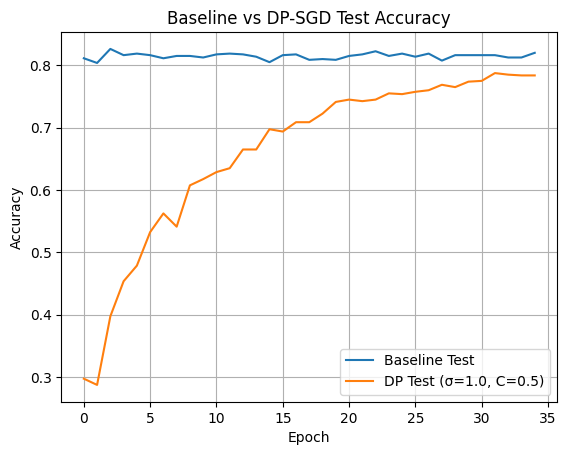

Best DP accuracy: 0.7875
DP ε value: 4.106264559537041


In [16]:
best_cfg = TrainConfig(lr=1e-3, dp=True, sigma=1.0, max_grad_norm=0.5, device=device)
best_dp_model = TextCNN(vocab_size, num_classes)
best_dp_model, best_dp_hist, best_dp_eps = train_one(best_dp_model, train_loader, test_loader, best_cfg)

plt.figure()
plt.plot(baseline_hist["test_acc"], label="Baseline Test")
plt.plot(best_dp_hist["test_acc"], label=f"DP Test (σ={1.0}, C={0.5})")
plt.title("Baseline vs DP-SGD Test Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.show()

print("Best DP accuracy:", max(best_dp_hist["test_acc"]))
print("DP ε value:", best_dp_eps)


# Experiment Summary and Results Export
# • Compiles key experiment metrics including baseline accuracy, best DP accuracy, privacy loss (ε), and chosen parameters.  
# • Saves the complete experiment summary as a JSON file for documentation and reproducibility.  
# • Confirms successful completion of the experiment and storage of results in the artifacts directory.

In [17]:
summary = {
    "baseline_best_acc": baseline_best,
    "dp_best_acc": best_dp["acc"],
    "dp_best_eps": best_dp["eps"],
    "best_params": best_dp,
    "label_classes": list(le.classes_),
    "vocab_size": vocab_size,
}
with open(os.path.join(outdir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Experiment completed. Summary saved to artifacts/summary.json")


Experiment completed. Summary saved to artifacts/summary.json
